<a href="https://colab.research.google.com/github/Dhoulnoun/fairuz-ML-project/blob/master/fairuz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le projet est de définir un modèle étant capable de prédire plus ou moins si un client bancaire va souscrire à un 'term deposit'.



---



Tout d’abord, encadrons le problème :

• **Est-ce un apprentissage supervisé, non supervisé ou par renforcement ?**

  C’est de l’apprentissage supervisé car chaque instance dispose d’une cible correspondante.


• **S’agit-il d’une tâche de classification, de régression ou autre ?**

  C’est une tâche de classification car nos cibles sont de nature catégorielle.

• **Devriez-vous utiliser des techniques d’apprentissage par lots (batch learning) ou d’apprentissage en ligne (online learning) ?**

  Nous devrions utiliser l’apprentissage par lots car notre dataset n’est pas très volumineux et n’est pas un flux de données en temps réel.


In [1]:
import pandas as pd
from scipy.io import arff

arff_file = arff.loadarff('/content/fairuz.arff')
df = pd.DataFrame(arff_file[0])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      45211 non-null  float64
 1   V2      45211 non-null  object 
 2   V3      45211 non-null  object 
 3   V4      45211 non-null  object 
 4   V5      45211 non-null  object 
 5   V6      45211 non-null  float64
 6   V7      45211 non-null  object 
 7   V8      45211 non-null  object 
 8   V9      45211 non-null  object 
 9   V10     45211 non-null  float64
 10  V11     45211 non-null  object 
 11  V12     45211 non-null  float64
 12  V13     45211 non-null  float64
 13  V14     45211 non-null  float64
 14  V15     45211 non-null  float64
 15  V16     45211 non-null  object 
 16  Class   45211 non-null  object 
dtypes: float64(7), object(10)
memory usage: 5.9+ MB


45211 entrées

17 features

On peut voir beaucoup de feature catégorielle qu'il nous sera nécessaire de traiter. De plus nous n'avons aucune feature avec des valeurs absentes



---






Maintenant voyons la répartition des features numériques

In [ ]:
df.describe()

,V1,V6,V10,V12,V13,V14,V15
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000



**V1** (âge): moyenne d'âge de 40 ans et allant de 18 à 95 ans

**V6** (montant moyen annuel sur le compte bancaire):  distribution très dispersée avec des valeurs négatives. Eventuellement, il serait intéressant de voir si les valeurs extrêmes sont nombreuses et s'il est pertinent de les garder dans le dataset.

**V10** (le derniers jour du mois où il a été contacté): moyenne de 15 logique car 30-31 jours dans un mois. Rien à signaler

**V12** (la durée du dernier contact en secondes): Ici aussi, nous retrouvons des valeurs extrêmes, il pourrait être pertinent de voir si elles sont nombreuses (comme pour la V6)

**V13** (nombre de fois que le client a été contacté durant cette campagne) : moyenne de 3 mais étendue de 1 à 63. Selon les quartiles les valeurs au dessus de 3 sont peu présentes. On pourrait supposer que les valeurs > 20 sont très rares.

**V14** (le nombre de jours passés depuis la dernière campagne marketing sur ce client): -1 signifie que le client n'a pas été contacté, d'où les valeurs négatives. Selon les quartiles, une grande partie des clients n'ont pas été contactées.

**V15** (nombre de fois que le client a été contacté avant la campagne actuelle): Selon les quartiles, la majorité des clients n'ont jamais été contacté précédemment.





---

Voyons la réparition des features catégorielles

In [ ]:
df['V2'].value_counts()

,count
V2,
b'blue-collar',9732
b'management',9458
b'technician',7597
b'admin.',5171
b'services',4154
b'retired',2264
b'self-employed',1579
b'entrepreneur',1487
b'unemployed',1303


In [ ]:
df['V3'].value_counts()

,count
V3,
b'married',27214
b'single',12790
b'divorced',5207


In [ ]:
df['V4'].value_counts()

,count
V4,
b'secondary',23202
b'tertiary',13301
b'primary',6851
b'unknown',1857


In [ ]:
df['V5'].value_counts()

,count
V5,
b'no',44396
b'yes',815


In [ ]:
df['V7'].value_counts()

,count
V7,
b'yes',25130
b'no',20081


In [ ]:
df['V8'].value_counts()

,count
V8,
b'no',37967
b'yes',7244


In [ ]:
df['V9'].value_counts()

,count
V9,
b'cellular',29285
b'unknown',13020
b'telephone',2906


In [ ]:
df['V11'].value_counts()

,count
V11,
b'may',13766
b'jul',6895
b'aug',6247
b'jun',5341
b'nov',3970
b'apr',2932
b'feb',2649
b'jan',1403
b'oct',738


In [ ]:
df['V16'].value_counts()

,count
V16,
b'unknown',36959
b'failure',4901
b'other',1840
b'success',1511


Toutes les features de catégorie semblent équilibrement répartie. Aucun traitement ne semble nécessaire.

---
**Analysons la matrice de corrélation de nos paires de features**

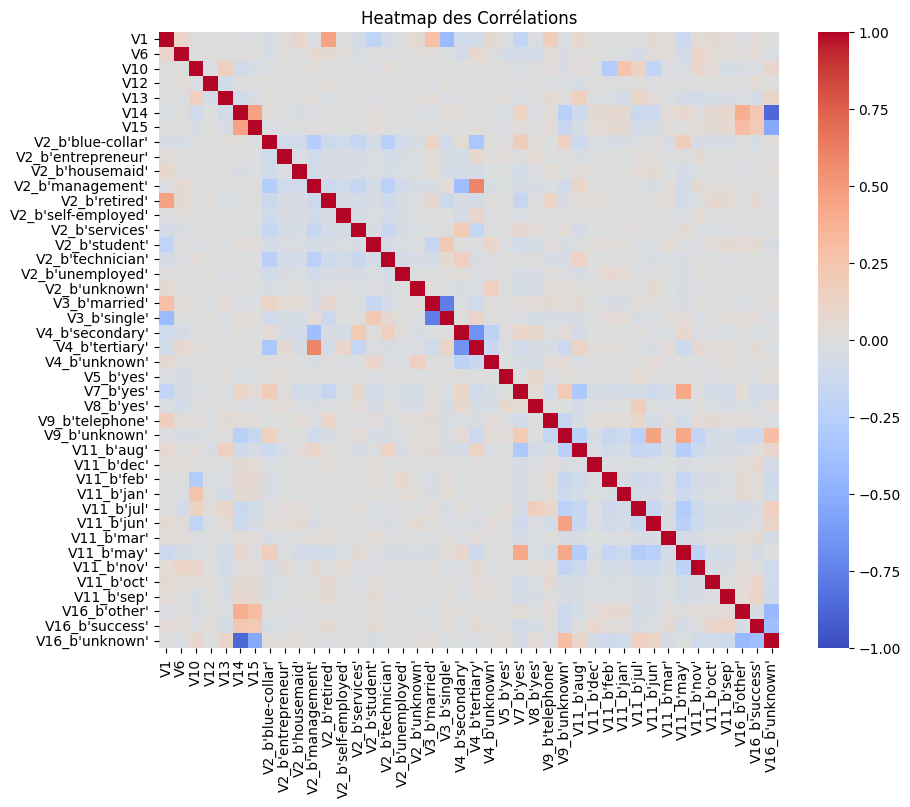

V14 - V16_b'unknown' : Corrélation = -0.87
V3_b'married' - V3_b'single' : Corrélation = -0.77
V3_b'single' - V3_b'married' : Corrélation = -0.77
V4_b'secondary' - V4_b'tertiary' : Corrélation = -0.66
V4_b'tertiary' - V4_b'secondary' : Corrélation = -0.66
V16_b'unknown' - V14 : Corrélation = -0.87


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Identifier les colonnes catégoriques
X = df.drop('Class', axis=1)  # Suppression de la colonne cible (target)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

# Appliquer One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' pour éviter la multicolinéarité
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convertir en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Remplacer les colonnes catégoriques dans X par leurs versions encodées
X_encoded = X.drop(columns=categorical_columns)  # Supprimer les colonnes catégoriques d'origine
X_encoded = pd.concat([X_encoded.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Calculer la matrice de corrélation
correlation_matrix = X_encoded.corr()

# Visualiser la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap des Corrélations")
plt.show()

# Trouver les paires fortement corrélées
threshold = 0.6
correlated_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if (correlation_matrix.loc[col1, col2] > threshold or correlation_matrix.loc[col1, col2] < -threshold)
    and col1 != col2
]
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]} : Corrélation = {pair[2]:.2f}")

On peut voir une corrélation forte entre **V14** et **V16**

**V14** étant le nombre de jours passés depuis la dernière campagne marketing sur ce client et V16 étant le résultat de cette précédente campagne (quand le résultat est inconnue)

La corrélation est logique car par exemple si une précédente campagne est trop récente, nous ne connaissons pas encore le résultat de celle-ci. De plus, il ne nous paraît pas nécessaire de supprimer l'une des deux features car leur correllation n'est pas redondante et ne concerne que le cas où le résultat de la campagne est inconnue.

---
**Répartition de la target**

Maintenant, analysons la répartition de valeur de notre target




In [ ]:
df['Class'].value_counts()

,count
Class,
b'1',39922
b'2',5289


On voit une répartition très largement en faveur de la valeur '1'.
Pour palier à ce problème nous avons plusieurs types de solutions.

*   Rerépartir les données par du sur-échantillonnage de la classe minoritaire (SMOTE) ou sous-échantillonnage de la classe majoritaire.
*   Utilisez des modèles qui sont efficaces même avec un déséquilibre comme random forest par exemple
*   Collectez des données supplémentaires (Impossible dans notre cas)
*   Lors de l’entraînement, appliquez des poids inversés proportionnels à la fréquence des classes pour équilibrer leur impact sur la fonction de perte.






---
**Sur-échantillonnage de la classe '2' minoritaire**

Nous avons choisi d'utiliser SMOTE

SMOTE permet d'éviter l'over-fitting car il ne crée pas de duplicats dans la dataset mais génère de nouveaux exemples synthétiques contrairement à l'oversampling classique. De plus, SMOTE ne génère pas de valeurs totalement aléatoires : il travaille en interpolant des points proches dans l’espace des features.



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Séparer les features et la target
X = df.drop('Class', axis=1)
y = df['Class']


# Identifier les colonnes catégoriques
categorical_columns = X.select_dtypes(include=['object']).columns

# Appliquer One-Hot Encoding aux colonnes catégoriques
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' pour éviter la multicolinéarité
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convertir les données encodées en DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Supprimer les colonnes originales catégoriques et les remplacer par les colonnes encodées
X = X.drop(columns=categorical_columns)
X = pd.concat([X.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


# Convertir les labels en format numérique si nécessaire
y = y.astype('int')

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Reconstruire un DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Class'])], axis=1)

# Vérification
print(df_resampled['Class'].value_counts())


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class
1    39922
2    39922
Name: count, dtype: int64


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

# Identifier les colonnes numériques uniquement (les catégoriques sont déjà encodées)
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Définir la transformation pour les colonnes numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # Standardiser les colonnes numériques uniquement
    ],
    remainder='passthrough'  # Laisser les autres colonnes (déjà encodées) inchangées
)

# Créer une pipeline avec le préprocesseur et RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5, n_estimators=100))
])

# Entraîner la pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer les performances
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[7593  392]
 [ 612 7372]]

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.95      0.94      7985
           2       0.95      0.92      0.94      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969



In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
print("Cross-validated F1-scores:", scores)
print("Mean F1-score:", scores.mean())

Cross-validated F1-scores: [0.69125186 0.88828355 0.84426713 0.75497936 0.66133116]
Mean F1-score: 0.7680226094218794


On vérifie les répartitions dans chaque pli

In [ ]:
for train_idx, test_idx in cv.split(X, y):
    print("Train class distribution:", y.iloc[train_idx].value_counts())
    print("Test class distribution:", y.iloc[test_idx].value_counts())

Train class distribution: Class
2    31938
1    31937
Name: count, dtype: int64
Test class distribution: Class
1    7985
2    7984
Name: count, dtype: int64
Train class distribution: Class
2    31938
1    31937
Name: count, dtype: int64
Test class distribution: Class
1    7985
2    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31937
Name: count, dtype: int64
Test class distribution: Class
2    7985
1    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31937
Name: count, dtype: int64
Test class distribution: Class
2    7985
1    7984
Name: count, dtype: int64
Train class distribution: Class
1    31938
2    31938
Name: count, dtype: int64
Test class distribution: Class
1    7984
2    7984
Name: count, dtype: int64


On peut voir que la répartition des classe est correcte dans l'ensembles des plis. Les mauvais scores avec random forest sur la cross validation ne sont donc pas liés à la réparition au sein des plis

---
**FINE-TUNING**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à tester
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Utiliser GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X, y)

# Meilleurs paramètres
print("Best Parameters:", grid_search.best_params_)

# Évaluation avec le meilleur modèle
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1_macro')
print("Optimized Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score after optimization:", cv_scores.mean())

KeyboardInterrupt: 

---
**Dataset non équillibré**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Diviser les features et la target
X = df.drop('Class', axis=1)
y = df['Class']

# Identifier les colonnes catégoriques et numériques
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Définir les transformations pour chaque type de données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),       # Standardiser les colonnes numériques
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Encodage One-Hot pour les colonnes catégoriques
    ]
)

# Créer une pipeline avec le préprocesseur et un modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Diviser le dataset en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Entraîner la pipeline
pipeline.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer les performances
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[7770  215]
 [ 649  409]]

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.97      0.95      7985
           2       0.66      0.39      0.49      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043



On peut voir que les prédictions faîtes par le modèle non sur échantillonné sont beaucoup moins précise que le dataset resampled. Nottamment sur la target 2, ce qui était attendu étant la sous-répartition de celle-ci


---
**LightGBM**

Au regard des résultats obtenus avec RandomForest, il peut être pertinent d'utiliser un autre modèle.
Nous allons utiliser:

**LightGBM (Light Gradient Boosting Machine)**


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split


# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Évaluation
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10652
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031
Confusion Matrix:
 [[7688  297]
 [ 508 7476]]

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.96      0.95      7985
           2       0.96      0.94      0.95      7984

    accuracy                           0.95     15969
   macro avg       0.95      0.95      0.95     15969
weighted avg       0.95      0.95      0.95     15969



**CROSS-VALIDATION**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Diviser les features et la target
X = df_resampled.drop('Class', axis=1)  # Utiliser le dataset réséchantillonné
y = df_resampled['Class']

# Définir le modèle
model = LGBMClassifier(random_state=42)

# Définir une validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser le F1-macro comme métrique pour des classes éventuellement déséquilibrées
f1_macro = make_scorer(f1_score, average='macro')

# Calculer les scores de validation croisée
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_macro)

# Afficher les résultats
print("Cross-Validation F1-scores:", cv_scores)
print("Mean F1-score:", cv_scores.mean())
print("Standard Deviation of F1-scores:", cv_scores.std())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10656
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 31938, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10657
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000031
[LightGBM] [Info] Start training from score 0.000031


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 31937, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10656
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499992 -> initscore=-0.000031
[LightGBM] [Info] Start training from score -0.000031


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 31937, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10657
[LightGBM] [Info] Number of data points in the train set: 63875, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499992 -> initscore=-0.000031
[LightGBM] [Info] Start training from score -0.000031


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 31938, number of negative: 31938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10653
[LightGBM] [Info] Number of data points in the train set: 63876, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Cross-Validation F1-scores: [0.94902156 0.94701257 0.94670248 0.95271363 0.94663605]
Mean F1-score: 0.9484172561308519
Standard Deviation of F1-scores: 0.0023199267219861847


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Cross-Validation **F1-scores**: [0.94902156 0.94701257 0.94670248 0.95271363 0.94663605]

Les résultats sont bien meilleurs.